<a href="https://colab.research.google.com/github/Mastroiani/TCC/blob/main/TCC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install plotly
!pip install unidecode
!pip install wordcloud
!pip install nltk
!pip install lxml
!pip install graphviz

<h1>
    Bibliotecas
</h1>
<hr>

In [221]:
import pandas as pd
import numpy as np
from unidecode import unidecode

import os
import re
from tqdm import tqdm
from time import time

import nltk
from nltk import FreqDist
from string import punctuation
from wordcloud import WordCloud

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from IPython.display import Image  
import pydotplus
import pickle

import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, cross_val_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.naive_bayes import CategoricalNB
from sklearn.svm import SVC
from sklearn.externals.six import StringIO  

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

<h1>
   Leitura da base de dados .csv e definição do dataframe 'df'
</h1>
<hr>

In [4]:
#definindo lista 'df_list' de arquivos para leitura

path = '/content/drive/MyDrive/DADOSTCC'
df_list = []
for file_name in os.listdir(path):
    df_list.append(pd.read_csv(
        f'{path}/{file_name}',
        sep='@',
        encoding='latin1' # Necessidade de uso desse enconder pela presenca de letras nao lidas pelo UTF-8
    ))


<h3>
    Criando o dataframe 'df', concatenando 'df_list'
</h3>

In [5]:
df = pd.concat(df_list)

if(df.shape[1] > 25):
    df = df.iloc[:,:-1]

print(df.shape)
df.head()

(118589, 25)


,NUMERO DE ORDEM,ANOMES,COD.NCM,DESCRICAO DO CODIGO NCM,PAIS,PAIS DE ORIGEM,PAIS.1,PAIS DE AQUISICAO,UND.ESTAT.,UNIDADE DE MEDIDA,UNIDADE COMERC.,DESCRICAO DO PRODUTO,QTDE ESTATISTICA,PESO LIQUIDO,VMLE DOLAR,VL FRETE DOLAR,VL SEGURO DOLAR,VALOR UN.PROD.DOLAR,QTD COMERCIAL.,TOT.UN.PROD.DOLAR,UNIDADE DESEMBARQUE,UNIDADE DESEMBARACO,INCOTERM,NAT.INFORMACAO,SITUACAO DO DESPACHO
0,962930000100001,202007,72021100,FERROMANGANÊS C/PESO + DE 2% D,756,AFRICA DO SUL,756,AFRICA DO SUL,10,QUILOGRAMA LIQUIDO,QUILOGRAMA LIQUIDO,CS215 - FERROMANGANES CONTENDO PESO MAIOR DE 2...,"20000,00000","20000,00000","30190,23","926,59","0,00","1,5510760","20000,00000","31021,5200000",N/INFORMADO,PORTO DO RIO DE JANEIRO,CFR,EFETIVA,DI DESEMBARAÇADA
1,745630000100001,202007,72021100,FERROMANGANÊS C/PESO + DE 2% D,361,INDIA,767,SUICA,10,QUILOGRAMA LIQUIDO,TONEL.METR.LIQ.,PEDIDO: 4512845335 CODIGO ITEM:20001208 FEMNAC...,"360000,00000","360000,00000","354981,62","13999,99","207,13","1015,0000000","360,00000","365400,0000000",N/INFORMADO,PORTO DO RIO DE JANEIRO,CFR,EFETIVA,DI DESEMBARAÇADA
2,745630000200001,202007,72021100,FERROMANGANÊS C/PESO + DE 2% D,361,INDIA,767,SUICA,10,QUILOGRAMA LIQUIDO,QUILOGRAMALIQUIDO,FERRO MANGANÊS ALTO CARBONO ...,"45000,00000","45000,00000","44372,71","1749,99","25,89","1,0150000","45000,00000","45675,0000000",N/INFORMADO,PORTO DO RIO DE JANEIRO,CFR,EFETIVA,DI DESEMBARAÇADA
3,1140420000100001,202007,72021100,FERROMANGANÊS C/PESO + DE 2% D,361,INDIA,361,INDIA,10,QUILOGRAMA LIQUIDO,TONELADAMETRICA,FERRO MANGANES ALTO CARBONO --> QUALIDADE QUIM...,"729000,00000","729000,00000","672540,33","31611,76","249,44","960,0000000","729,00000","699840,0000000",N/INFORMADO,ALF - FORTALEZA,CFR,EFETIVA,DI DESEMBARAÇADA
4,233250000100001,202007,72021100,FERROMANGANÊS C/PESO + DE 2% D,756,AFRICA DO SUL,756,AFRICA DO SUL,10,QUILOGRAMA LIQUIDO,QUILOGRAMA LIQUIDO,CS215 - FERROMANGANES CONTENDO PESO MAIOR DE 2...,"20000,00000","20000,00000","29497,04","924,46","0,00","1,5162978","20000,00000","30325,9560000",N/INFORMADO,PORTO DO RIO DE JANEIRO,CFR,EFETIVA,DI DESEMBARAÇADA


<h2>Normalizando as colunas de 'df'</h2>
<hr>

In [6]:
#transpõe rótulos das colunas para letras minúsculas e acrescenta "_" entre palavras
df.columns = ["_".join(re.findall(r'\w+',col)).lower() for col in df.columns]

#função 'norm_num': altera caracter "," para "." e "." para ""
def norm_num(num):
    return float(str(num).replace(".","").replace(",","."))

#função 'norm': usa biblioteca de expressões regulares para transpor palavras maiúsculas em minúsculas
def norm(text):
    return " ".join(re.findall(r'\w+',text)).lower()


In [7]:
for column in [
    'qtde_estatistica',
    'peso_liquido',
    'vmle_dolar',
    'vl_frete_dolar',
    'vl_seguro_dolar',
    'valor_un_prod_dolar',
    'qtd_comercial',
    'tot_un_prod_dolar',
    'und_estat'
    ]:
    df[column] = df[column].apply(lambda x: norm_num(x))
    
df['unidade_desembaraco'] = df['unidade_desembaraco'].apply(lambda x: norm(x))
df['pais_de_origem'] = df['pais_de_origem'].apply(lambda x: norm(x))
df['pais_de_aquisicao'] = df['pais_de_aquisicao'].apply(lambda x: norm(x))

df.head()

,numero_de_ordem,anomes,cod_ncm,descricao_do_codigo_ncm,pais,pais_de_origem,pais_1,pais_de_aquisicao,und_estat,unidade_de_medida,unidade_comerc,descricao_do_produto,qtde_estatistica,peso_liquido,vmle_dolar,vl_frete_dolar,vl_seguro_dolar,valor_un_prod_dolar,qtd_comercial,tot_un_prod_dolar,unidade_desembarque,unidade_desembaraco,incoterm,nat_informacao,situacao_do_despacho
0,962930000100001,202007,72021100,FERROMANGANÊS C/PESO + DE 2% D,756,africa do sul,756,africa do sul,10.0,QUILOGRAMA LIQUIDO,QUILOGRAMA LIQUIDO,CS215 - FERROMANGANES CONTENDO PESO MAIOR DE 2...,20000.0,20000.0,30190.23,926.59,0.00,1.551076,20000.0,31021.520,N/INFORMADO,porto do rio de janeiro,CFR,EFETIVA,DI DESEMBARAÇADA
1,745630000100001,202007,72021100,FERROMANGANÊS C/PESO + DE 2% D,361,india,767,suica,10.0,QUILOGRAMA LIQUIDO,TONEL.METR.LIQ.,PEDIDO: 4512845335 CODIGO ITEM:20001208 FEMNAC...,360000.0,360000.0,354981.62,13999.99,207.13,1015.000000,360.0,365400.000,N/INFORMADO,porto do rio de janeiro,CFR,EFETIVA,DI DESEMBARAÇADA
2,745630000200001,202007,72021100,FERROMANGANÊS C/PESO + DE 2% D,361,india,767,suica,10.0,QUILOGRAMA LIQUIDO,QUILOGRAMALIQUIDO,FERRO MANGANÊS ALTO CARBONO ...,45000.0,45000.0,44372.71,1749.99,25.89,1.015000,45000.0,45675.000,N/INFORMADO,porto do rio de janeiro,CFR,EFETIVA,DI DESEMBARAÇADA
3,1140420000100001,202007,72021100,FERROMANGANÊS C/PESO + DE 2% D,361,india,361,india,10.0,QUILOGRAMA LIQUIDO,TONELADAMETRICA,FERRO MANGANES ALTO CARBONO --> QUALIDADE QUIM...,729000.0,729000.0,672540.33,31611.76,249.44,960.000000,729.0,699840.000,N/INFORMADO,alf fortaleza,CFR,EFETIVA,DI DESEMBARAÇADA
4,233250000100001,202007,72021100,FERROMANGANÊS C/PESO + DE 2% D,756,africa do sul,756,africa do sul,10.0,QUILOGRAMA LIQUIDO,QUILOGRAMA LIQUIDO,CS215 - FERROMANGANES CONTENDO PESO MAIOR DE 2...,20000.0,20000.0,29497.04,924.46,0.00,1.516298,20000.0,30325.956,N/INFORMADO,porto do rio de janeiro,CFR,EFETIVA,DI DESEMBARAÇADA


<h1>Separando colunas</h1>
<ul>
    <li>Número de ordem -> ordem, adição e produto</li>
    <li>Ano e mês -> Ano e mês</li>
</ul>
<hr>

In [8]:
numero_de_ordem = df['numero_de_ordem'].copy().astype(str).to_list()
ano_mes = df['anomes'].copy().astype(str).to_list()

In [9]:
adicao = []
produto = []
ordem = []
ano = []
mes = []

for num_ordem, ano_me in zip(numero_de_ordem,ano_mes):
    ordem.append(num_ordem[:-10])
    adicao.append(num_ordem[-10:-5])
    produto.append(num_ordem[-5:])
    ano.append(ano_me[:4])
    mes.append(ano_me[-2:])

In [10]:
df['numero_de_ordem'] = ordem
i = 1
for col in [['adicao',adicao],['produto',produto]]:
    try:
        df.insert(i,col[0],col[1]) # adicionando a coluna adicao
    except:
        print('Coluna ja existente')
    finally:
        i += 1
        
df.insert(3,'ano',ano)
df.insert(4,'mes',mes)

df.drop(['anomes'],axis=1,inplace=True)
df.sort_values(by=['ano'],inplace=True)

In [11]:
df.head(2)

,numero_de_ordem,adicao,produto,ano,mes,cod_ncm,descricao_do_codigo_ncm,pais,pais_de_origem,pais_1,pais_de_aquisicao,und_estat,unidade_de_medida,unidade_comerc,descricao_do_produto,qtde_estatistica,peso_liquido,vmle_dolar,vl_frete_dolar,vl_seguro_dolar,valor_un_prod_dolar,qtd_comercial,tot_un_prod_dolar,unidade_desembarque,unidade_desembaraco,incoterm,nat_informacao,situacao_do_despacho
0,96293,00001,00001,2020,07,72021100,FERROMANGANÊS C/PESO + DE 2% D,756,africa do sul,756,africa do sul,10.0,QUILOGRAMA LIQUIDO,QUILOGRAMA LIQUIDO,CS215 - FERROMANGANES CONTENDO PESO MAIOR DE 2...,20000.0,20000.0,30190.23,926.59,0.00,1.551076,20000.000,31021.520000,N/INFORMADO,porto do rio de janeiro,CFR,EFETIVA,DI DESEMBARAÇADA
1920,59316,00001,00011,2020,11,72123000,OUTS.LAM.PLANOS GALV.P/OUTRO P,607,portugal,607,portugal,10.0,QUILOGRAMA LIQUIDO,Tonelada,"CHAPA LAMINADA PLANA DE ACO, ZINCADA, EM ROLO....",106149.0,106149.0,105185.53,8012.61,34.92,1141.455995,3.364,3839.857968,N/INFORMADO,porto de manaus,CFR,EFETIVA,DI DESEMBARAÇADA


<h1>Verificando dados incompletos (nulos) e redundantes (duplicados)</h1>
<hr>

In [12]:
print(df.isna().sum())
df.dropna(inplace=True)

numero_de_ordem            0
adicao                     0
produto                    0
ano                        0
mes                        0
cod_ncm                    0
descricao_do_codigo_ncm    0
pais                       0
pais_de_origem             0
pais_1                     0
pais_de_aquisicao          0
und_estat                  0
unidade_de_medida          0
unidade_comerc             0
descricao_do_produto       0
qtde_estatistica           0
peso_liquido               0
vmle_dolar                 0
vl_frete_dolar             0
vl_seguro_dolar            0
valor_un_prod_dolar        0
qtd_comercial              0
tot_un_prod_dolar          0
unidade_desembarque        0
unidade_desembaraco        0
incoterm                   0
nat_informacao             0
situacao_do_despacho       0
dtype: int64


In [13]:
df.isnull().sum()

numero_de_ordem            0
adicao                     0
produto                    0
ano                        0
mes                        0
cod_ncm                    0
descricao_do_codigo_ncm    0
pais                       0
pais_de_origem             0
pais_1                     0
pais_de_aquisicao          0
und_estat                  0
unidade_de_medida          0
unidade_comerc             0
descricao_do_produto       0
qtde_estatistica           0
peso_liquido               0
vmle_dolar                 0
vl_frete_dolar             0
vl_seguro_dolar            0
valor_un_prod_dolar        0
qtd_comercial              0
tot_un_prod_dolar          0
unidade_desembarque        0
unidade_desembaraco        0
incoterm                   0
nat_informacao             0
situacao_do_despacho       0
dtype: int64

In [14]:
df.duplicated(['numero_de_ordem','adicao','produto','ano','mes']).sum()

0

<h1>Criando dataframe 'df_filtrado', filtrando atributos de interesse de 'df'</h1>
<hr>
<ul>
    <li>NCM: <strong>72172090</strong></li>
    <li>Natureza Informação: <strong>efetiva</strong></li>
    <li>Situação do Despacho: <strong>di desembaraçada</strong></li>
</ul>

In [15]:
df_filtrado = df[df['cod_ncm'] == 72172090].copy()
df_filtrado['nat_informacao'] = df_filtrado['nat_informacao'].apply(lambda x: norm(x))
df_filtrado['situacao_do_despacho'] = df_filtrado['situacao_do_despacho'].apply(lambda x: norm(x))

df_filtrado = df_filtrado[df_filtrado['nat_informacao'] == 'efetiva']
df_filtrado = df_filtrado[df_filtrado['situacao_do_despacho'] == 'di desembaraçada']

df_filtrado.shape

(1512, 28)

<h1>Agrupando e rateando valores de:</h1>
<ul>
    <li>Peso Liquido</li>
    <li>Valor Frete</li>
    <li>Valor Seguro</li>
    <li>Total Unitário</li>
</ul>
<hr>

In [16]:
grupos_index = df_filtrado['numero_de_ordem'].value_counts().index
grupos_index

Index(['9562', '149237', '51382', '210283', '110021', '149325', '173965',
       '120740', '31021', '167077',
       ...
       '51345', '132294', '177817', '107692', '105339', '25046', '4042',
       '178466', '85336', '16252'],
      dtype='object', length=693)

<h3>Peso Liquido Rataedo e Valor Frete Rateado</h3>

In [17]:
list_aux = [] # objeto auxiliar de armazenamento das variáveis 'peso_liquido_rateado' e 'valor_frete_rateado' que serão criadas abaixo

for grupo in tqdm(grupos_index): #agrupando 'adicao' do mesmo 'numero_de_ordem' 
    aux = df_filtrado[df_filtrado['numero_de_ordem'] == grupo].copy() 
    
    sub_grupos_adicao = aux['adicao'].value_counts().index
    
    for sub_adicao in sub_grupos_adicao:  #agrupando produtos da mesmo 'adicao'
        aux_2 = aux[aux['adicao'] == sub_adicao].copy()
        
        qtd_comercial = aux_2['qtd_comercial'] #soma qtd comercial de produtos agrupados por 'numero_de_ordem' e 'adicao'
        soma_qtd_comercial = sum(qtd_comercial)

        
        peso_liquido = aux_2['peso_liquido']
        vl_frete_dolar = aux_2['vl_frete_dolar']
        

        aux_2['peso_liquido_rateado'] = (qtd_comercial/soma_qtd_comercial)*peso_liquido
        aux_2['valor_frete_rateado'] = (qtd_comercial/soma_qtd_comercial)*vl_frete_dolar

        list_aux.append(aux_2)
        
        
df_filtrado = pd.concat(list_aux)
df_filtrado.shape

100%|██████████| 693/693 [00:02<00:00, 256.91it/s]


(1512, 30)

<h3>Seguro Rateado</h3>

In [18]:
list_aux = [] # objeto auxiliar de armazenamento da variáveis 'seguro_rateado'
for grupo in tqdm(grupos_index):
    aux = df_filtrado[df_filtrado['numero_de_ordem'] == grupo].copy()
    
    sub_grupos_adicao = aux['adicao'].value_counts().index
    
    for sub_adicao in sub_grupos_adicao:
        aux_2 = aux[aux['adicao'] == sub_adicao].copy()
        
        total_unitario = aux_2['tot_un_prod_dolar']
        soma_total_unitario = sum(total_unitario)
        

        vl_seguro_dolar = aux_2['vl_seguro_dolar']
        aux_2['seguro_rateado'] = (total_unitario/soma_total_unitario)*vl_seguro_dolar

        list_aux.append(aux_2)
        
        
df_filtrado = pd.concat(list_aux)

100%|██████████| 693/693 [00:02<00:00, 333.85it/s]


In [19]:
df_filtrado.shape

(1512, 31)

<h3>Total Unitario Rateado</h3>
<p>Necessário subtrair 'valor_frete_rateado' e 'seguro_rateado' para INCOTERMS distintos de FOB/FCA/EXW</p>

In [20]:
total_unitario_list = [] # objeto auxiliar de armazenamento da variáveis 'total_unitario_rateado'
for row_ in tqdm(df_filtrado.iloc,total=df_filtrado.shape[0]):
    total_unitario = row_['tot_un_prod_dolar']
    
    if(row_['incoterm'][0] == 'F' or row_['incoterm'][0] == 'E'):
        total_unitario_list.append(total_unitario)
    else:
        total_unitario_list.append(total_unitario - row_['valor_frete_rateado'] - row_['seguro_rateado'])

df_filtrado['total_unitario_rateado'] = total_unitario_list

100%|██████████| 1512/1512 [00:00<00:00, 5499.60it/s]


In [21]:
df_filtrado.shape

(1512, 32)

<h3>Criando Coluna FOB/KG</h3>
<p>Dividindo a coluna calculada <em><strong>total_unitario_rateado</strong></em> pela coluna calculada <em><strong>peso_liquido_rateado</strong></em></p>
<hr>

In [22]:
df_filtrado['fob_kg'] = df_filtrado['total_unitario_rateado']/df_filtrado['peso_liquido_rateado']

<h3>Remoção de unidades comerciais (atributos) não relevantes</h3>
<hr>

<p>Obs.: esse ajuste visa considerar apenas os registros de produtos com unidade comercial relacionada a unidade estatística (Kg)</p> 

In [23]:
df_filtrado['unidade_comerc'] = df_filtrado['unidade_comerc'].apply(lambda x: x.lower())

<p>Verificando as unidades comerciais presentes</p>

In [24]:
freq_unid_com = FreqDist(df_filtrado['unidade_comerc'].values)
freq_unid_com

FreqDist({'12000               ': 1,
          'bobina              ': 37,
          'bobinas             ': 8,
          'caixa               ': 5,
          'caixas              ': 21,
          'carretel            ': 18,
          'kg                  ': 5,
          'kg liquido          ': 1,
          'kilograma           ': 147,
          'kilogramas          ': 12,
          'kilos               ': 1,
          'metro               ': 2,
          'metros              ': 3,
          'metrotoneladas      ': 2,
          'peca                ': 30,
          'pecas               ': 19,
          'peças               ': 2,
          'pé                  ': 1,
          'quiligroma          ': 1,
          'quilo               ': 71,
          'quilograma          ': 80,
          'quilograma liquido  ': 243,
          'quilogramaliqui     ': 1,
          'quilogramaliquido   ': 9,
          'quilogramas         ': 3,
          'quilogramo liqu.    ': 25,
          'quilogrmaliqui

<p>Removendo:</p>
        <ul>
            <li><strong>caixa</strong></li>
            <li><strong>caixas</strong></li>
            <li><strong>carretel</strong></li>
            <li><strong>pacote</strong></li>
            <li><strong>pacotes</strong></li>
            <li><strong>peca</strong></li>
            <li><strong>pecas</strong></li>
            <li><strong>peças</strong></li>
            <li><strong>pé</strong></li>
            <li><strong>rolo</strong></li>
            <li><strong>rolos</strong></li>
            <li><strong>sachet</strong></li>
            <li><strong>sacos</strong></li>
            <li><strong>unidade</strong></li>
            <li><strong>metro</strong></li>
            <li><strong>metros</strong></li>
        </ul>

In [25]:
def search_unid_comer(text):
    
    text = norm(text)
    achou = False
    for comparador in [
        'caixa',
        'caixas',
        'carretel',
        'pacote',
        'pacotes',
        'peca',
        'pecas',
        'peças',
        'pé',
        'rolo',
        'rolos',
        'sachet',
        'sacos',
        'unidade',
        'metro', # arrumar para tirar somente que for exatamente igual
        'metros' # arrumar para tirar somente que for exatamente igual
        ]:
        if(comparador in ['metro','metros']):
            if(text == comparador):
                achou = True
                return False
        elif(re.search(unidecode(comparador),unidecode(text))):
            achou = True
            return False
    if(not achou):
        return text

df_filtrado['unidade_comerc'] = df_filtrado['unidade_comerc'].apply(lambda x: search_unid_comer(x))
df_filtrado = df_filtrado[df_filtrado['unidade_comerc'] != False]

print(df_filtrado.shape)

(1296, 33)


<h3>Descrição do Produto</h3>
<hr>

<p>Obs.: esse ajuste visa considerar apenas os registros de produtos com descrição de produto sem menção de cobertura, pintura e/ou com aplicação especial (óptica)</p>

In [26]:
df_filtrado['descricao_do_produto'] = df_filtrado['descricao_do_produto'].apply(lambda x: x.lower())

# função para remover stopwords e tokenizar
def norm_nltk(text):
    stop_word = nltk.corpus.stopwords.words('portuguese')

    tokens = nltk.word_tokenize(text.lower(),language='portuguese')
    tokens = [token for token in tokens if token not in stop_word]
    tokens = [token for token in tokens if token not in punctuation]

    aux = []
    for token in tokens:
        if(not re.findall(r'[0-9]+',token)):
            aux.append(unidecode(token))
    tokens = aux
    return " ".join(tokens)

df_filtrado['descricao_do_produto'] = df_filtrado['descricao_do_produto'].apply(lambda x: norm_nltk(x))

In [27]:
df_filtrado['descricao_do_produto'].head()

3842    arame aco ligado galvanizado tipo industrial a...
3843    arame aco ligado galvanizado tipo industrial a...
3844    arame aco ligado galvanizado tipo industrial a...
3845    arame aco ligado galvanizado tipo comercial ac...
3846    arame aco ligado galvanizado tipo comercial ac...
Name: descricao_do_produto, dtype: object

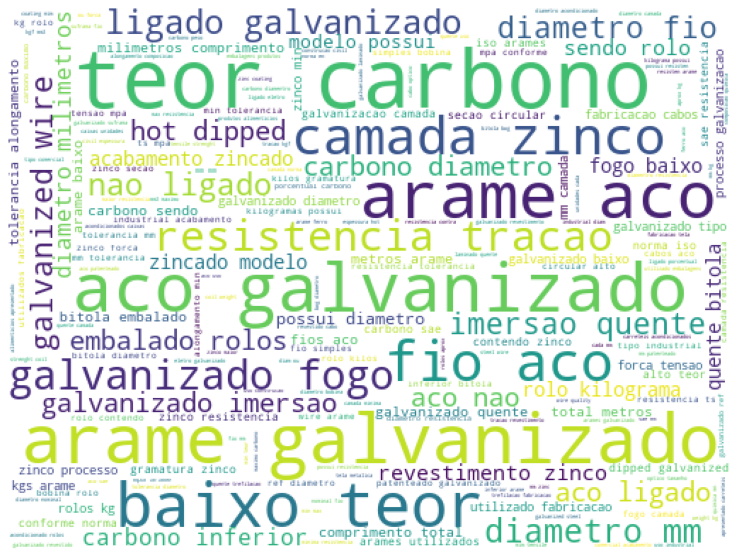

In [28]:
plt.subplots(figsize = (15,10))

wordcloud = WordCloud (
                    background_color = 'white',
                    width = 512,
                    height = 384
                        ).generate(' '.join(df_filtrado['descricao_do_produto']))
plt.imshow(wordcloud) 
plt.axis('off')
plt.show()

In [29]:
ls_df_filtrado = list(df_filtrado['descricao_do_produto'].values)
str_ls = " ".join(ls_df_filtrado)
#print(str_ls)
palavras=nltk.word_tokenize(str_ls)
freq_desc_prod = FreqDist(palavras)
freq_desc_prod 

FreqDist({"''": 10,
          '**suframa**fio': 27,
          '+-': 59,
          '+/-': 233,
          '+ou': 16,
          '+ou-': 7,
          '-ex': 1,
          '-h': 1,
          '.fio': 3,
          '.t': 8,
          '.te': 1,
          '.teo': 3,
          '.teor': 4,
          '.tolerancia': 6,
          '//': 12,
          '/diametro': 1,
          '1/2': 4,
          '2': 2,
          '?': 6,
          '``': 5,
          'aao': 1,
          'abaixo': 4,
          'abnt': 2,
          'acabamento': 120,
          'acer': 4,
          'achatado': 1,
          'acima': 17,
          'aco': 955,
          'acomodados': 2,
          'acondicionado': 44,
          'acondicionados': 42,
          'acsr': 2,
          'ada': 1,
          'aeo': 2,
          'agropecuario': 1,
          'agrupados': 5,
          'ai': 2,
          'ajax': 4,
          'al': 5,
          'alam': 3,
          'alambrados': 7,
          'alambrados.forma': 12,
          'alambre': 1,
          'aliment

<p>Removendo produtos de descrição com palavras verificadas como não relevantes:</p>
        



In [30]:
def search_desc_prod(text):
    text = text.lower()
    achou = False
    for comparador in [
            'aluminio',
            'aluminio-liga',
            'plastico',
            'plasticos',
            'plasticos.utilizacao',
            'pvc',
            'policloreto',
            'polietileno',
            'polimericos',
            'polimeros',
            'polipropileno',
            'vinila',
            'preto',
            'prata',
            'branca',
            'branco',
            'verde',
            'azul',
            'brilho',                     
            'otica',
            'optico',
            'optica',
            'mascara',
            'mascaras',
            'mask',
            'laca'            
        ]:
        
        if(re.search(unidecode(comparador),unidecode(text))):
            achou = True
            return False
    if(not achou):
        return text

df_filtrado['descricao_do_produto'] = df_filtrado['descricao_do_produto'].apply(lambda x: search_desc_prod(x))
df_filtrado = df_filtrado[df_filtrado['descricao_do_produto'] != False]

<h3>Tamanho do DataFrame final</h3>
<hr>

In [31]:
df_filtrado.shape

(1167, 33)

<h1>Comparando valor FOB/KG com valor de cotação mensal internacional da matéria-prima (Wire Rod - Fio Máquina)</h1>
<hr>

<h3>Leitura dos dados de cotação da página web de referência</h3>

In [32]:
URL = 'https://mepsinternational.com/gb/en/products/world-steel-prices'

df_wire_rod = pd.read_html(URL,match='Wire Rod')[0]
df_wire_rod

,Month,Hot Rolled Coil,Hot Rolled Plate,Cold Rolled Coil,Hot Dipped Galvanised Coil,Electro Zinc Coated Coil,Wire Rod,Sections & Beams,Rebar,Merchant Bar
0,Jul-2020,517.0,573.0,624.0,728.0,756.0,548.0,656.0,524.0,615.0
1,Aug-2020,531.0,580.0,633.0,738.0,764.0,555.0,668.0,536.0,623.0
2,Sep-2020,591.0,605.0,694.0,804.0,823.0,578.0,679.0,555.0,632.0
3,Oct-2020,638.0,620.0,741.0,853.0,870.0,587.0,693.0,563.0,647.0
4,Nov-2020,671.0,630.0,780.0,890.0,901.0,602.0,696.0,567.0,651.0
5,Dec-2020,766.0,699.0,874.0,982.0,994.0,637.0,728.0,609.0,688.0
6,Jan-2021,924.0,847.0,1022.0,1134.0,1143.0,772.0,884.0,738.0,815.0
7,Feb-2021,968.0,885.0,1091.0,1203.0,1215.0,798.0,907.0,741.0,828.0
8,Mar-2021,1033.0,933.0,1156.0,1271.0,1281.0,805.0,919.0,752.0,840.0
9,Apr-2021,1129.0,999.0,1254.0,1372.0,1386.0,806.0,918.0,756.0,836.0


<h3>Definindo dataframe 'df_wire_rod'</h3>

In [33]:
df_wire_rod = df_wire_rod[['Month','Wire Rod']].copy().dropna()
df_wire_rod['Wire Rod'] = df_wire_rod['Wire Rod'].apply(lambda x: x/1000)
df_wire_rod

,Month,Wire Rod
0,Jul-2020,0.548
1,Aug-2020,0.555
2,Sep-2020,0.578
3,Oct-2020,0.587
4,Nov-2020,0.602
5,Dec-2020,0.637
6,Jan-2021,0.772
7,Feb-2021,0.798
8,Mar-2021,0.805
9,Apr-2021,0.806


In [34]:
#exportando 'df_wire_rod' em formato csv
df_wire_rod.to_csv('/content/drive/MyDrive/wire_rod.csv',index=False)

<h3>Visualização gráfica da evolução da cotação do Wire Rod</h3>

In [35]:
fig = px.line(
    df_wire_rod,
    x="Month", 
    y="Wire Rod", 
    title="Variação do Wire Rod",
    text='Wire Rod'
)
fig.update_traces(textposition="bottom right")
fig.show()

<h3>Comparação</h3>
<p>Comparação do <strong>valor FOB/KG do produto manufaturado</strong> com o valor de <strong> cotação mensal internacional da matéria-prima (Wire Rod)</strong>; visa identificar se existe incompatibilidade de valor declarado (1 - True) ou não (0 - False)</p>

In [36]:
map_mes = {
    '01': 'Jan',
    '02': 'Feb',
    '03': 'Mar',
    '04': 'Apr',
    '05': 'May',
    '06': 'Jun',
    '07': 'Jul',
    '08': 'Aug',
    '09': 'Sep',
    '10': 'Oct',
    '11': 'Nov',
    '12': 'Dec'
    }

In [37]:
aux = []
wire_rod_list = []
for row_ in df_filtrado.iloc:
    
    try:
        wire_rod = df_wire_rod[df_wire_rod['Month'] == f"{map_mes[row_['mes']]}-{row_['ano']}"]['Wire Rod'].values[0]
        wire_rod_list.append(wire_rod)
        if(row_['fob_kg'] < wire_rod):
            aux.append(1)
        else:
            aux.append(0)
    except:
        aux.append(None)
        wire_rod_list.append(None)
        
df_filtrado['cotacao'] = wire_rod_list
df_filtrado['incompatibil'] = aux

In [38]:
df_filtrado.shape

(1167, 35)

<h1>Visualização dos dados</h1>
<hr>

In [39]:
df_filtrado.reset_index(inplace=True,drop=True)

expo_df = df_filtrado[[
    'numero_de_ordem',
    'adicao',
    'produto',
    'ano',
    'mes',
    'pais_de_origem',
    'unidade_desembaraco',
    'pais_de_aquisicao',
    'peso_liquido',
    'qtd_comercial',
    'vl_frete_dolar',
    'vl_seguro_dolar',
    'tot_un_prod_dolar',
    'peso_liquido_rateado',
    'valor_frete_rateado',
    'seguro_rateado',
    'total_unitario_rateado',
    'fob_kg',
    'cotacao',
    'incompatibil'
]]
expo_df['incompatibil'] = expo_df['incompatibil'].apply(lambda x: 'Sim' if x == 1 else 'Nao')
expo_df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,numero_de_ordem,adicao,produto,ano,mes,pais_de_origem,unidade_desembaraco,pais_de_aquisicao,peso_liquido,qtd_comercial,vl_frete_dolar,vl_seguro_dolar,tot_un_prod_dolar,peso_liquido_rateado,valor_frete_rateado,seguro_rateado,total_unitario_rateado,fob_kg,cotacao,incompatibil
0,149237,00001,00009,2021,02,china republica pop,itajai,china republica pop,258833.0,9000.0,53500.0,352.48,6624.000,9000.0,1860.272840,11.218297,6624.000,0.736,0.798,Sim
1,149237,00001,00010,2021,02,china republica pop,itajai,china republica pop,258833.0,26000.0,53500.0,352.48,20072.000,26000.0,5374.121538,33.993608,20072.000,0.772,0.798,Sim
2,149237,00001,00011,2021,02,china republica pop,itajai,china republica pop,258833.0,15000.0,53500.0,352.48,12675.000,15000.0,3100.454733,21.466171,12675.000,0.845,0.798,Nao
3,149237,00001,00012,2021,02,china republica pop,itajai,china republica pop,258833.0,35.0,53500.0,352.48,34.475,35.0,7.234394,0.058386,34.475,0.985,0.798,Nao
4,149237,00001,00013,2021,02,china republica pop,itajai,china republica pop,258833.0,19.0,53500.0,352.48,19.095,19.0,3.927243,0.032339,19.095,1.005,0.798,Nao


In [40]:
print(expo_df.isna().sum())

numero_de_ordem           0
adicao                    0
produto                   0
ano                       0
mes                       0
pais_de_origem            0
unidade_desembaraco       0
pais_de_aquisicao         0
peso_liquido              0
qtd_comercial             0
vl_frete_dolar            0
vl_seguro_dolar           0
tot_un_prod_dolar         0
peso_liquido_rateado      0
valor_frete_rateado       0
seguro_rateado            0
total_unitario_rateado    0
fob_kg                    0
cotacao                   0
incompatibil              0
dtype: int64


In [41]:
expo_df[expo_df['cotacao'].isna()]

,numero_de_ordem,adicao,produto,ano,mes,pais_de_origem,unidade_desembaraco,pais_de_aquisicao,peso_liquido,qtd_comercial,vl_frete_dolar,vl_seguro_dolar,tot_un_prod_dolar,peso_liquido_rateado,valor_frete_rateado,seguro_rateado,total_unitario_rateado,fob_kg,cotacao,incompatibil


In [42]:
fig = px.scatter(expo_df,x='fob_kg', y='peso_liquido')#color='incompatibil')

fig.show()

In [43]:
fig = px.scatter(expo_df,x='unidade_desembaraco', y='pais_de_origem',color='incompatibil')
fig.show()

<h1>Nota</h1>
<p>Reduzimos a proporção dos dados através do <strong>Logarítmico</strong>, uma técnica usada para melhor visualização dos dados</p>

In [44]:
import plotly.graph_objects as go

for year in ['2020','2021']:
    medias = []


    df_2021 = df_filtrado[df_filtrado['ano'] == year]
    mes_grupos = df_2021['mes'].value_counts().index
    for mes_grup in mes_grupos:
        medias.append([mes_grup,df_2021[df_2021['mes'] == mes_grup]['fob_kg'].to_list()])

    medias = sorted(medias,key=lambda x: x[0])
    
    fig = go.Figure()
    for x in medias:
        fig.add_trace(go.Box(y=[np.log2(y) for y in x[1]],name=map_mes[x[0]]))

    fig.update_layout(
        title=go.layout.Title(
            text=f"Análise durante o ano de {year}",
            xref="paper",
            x=0
        )
        )

    fig.show()

In [45]:
info_pais_origem = df_filtrado[df_filtrado['incompatibil'] == 1]['pais_de_origem'].value_counts()

labels = info_pais_origem.index
values = info_pais_origem.to_list()


import plotly.graph_objects as go


fig = go.Figure([go.Bar(x=values, y=labels, orientation='h')])
fig.update_layout(
    title=go.layout.Title(
        text="Países de origem <br><sup>Produtos com valor declarado incompatível",
        xref="paper",
        x=0
    )
    )
fig.show()

In [46]:
info_pais_origem = df_filtrado[df_filtrado['incompatibil'] == 1]['pais_de_origem'].value_counts()

labels = info_pais_origem.index
values = info_pais_origem.to_list()


import plotly.graph_objects as go

fig = go.Figure(data=[go.Pie(labels=labels, values=values)])
fig.show()

In [47]:
info_pais_origem = df_filtrado['pais_de_origem'].value_counts()

labels = info_pais_origem.index
values = info_pais_origem.to_list()


import plotly.graph_objects as go


fig = go.Figure([go.Bar(x=values, y=labels, orientation='h')])
fig.update_layout(
    title=go.layout.Title(
        text="Países de origem <br><sup>Todos Produtos",
        xref="paper",
        x=0
    )
    )
fig.show()

In [48]:
info_pais_origem = df_filtrado['pais_de_origem'].value_counts()

labels = info_pais_origem.index
values = info_pais_origem.to_list()


import plotly.graph_objects as go

fig = go.Figure(data=[go.Pie(labels=labels, values=values)])
fig.show()

In [49]:
info_pais_origem = df_filtrado[df_filtrado['incompatibil'] == 1]['pais_de_aquisicao'].value_counts()

labels = info_pais_origem.index
values = info_pais_origem.to_list()


import plotly.graph_objects as go


fig = go.Figure([go.Bar(x=values, y=labels, orientation='h')])
fig.update_layout(
    title=go.layout.Title(
        text="País de Aquisição<br><sup>Produtos com valor declarado incompatível</sup>",
        xref="paper",
        x=0
    )
    )
fig.show()

In [50]:
info_pais_origem = df_filtrado[df_filtrado['incompatibil'] == 1]['pais_de_origem'].value_counts()

labels = info_pais_origem.index
values = info_pais_origem.to_list()


import plotly.graph_objects as go

fig = go.Figure(data=[go.Pie(labels=labels, values=values)])
fig.show()

In [51]:
info_pais_origem = df_filtrado['pais_de_aquisicao'].value_counts()

labels = info_pais_origem.index
values = info_pais_origem.to_list()


import plotly.graph_objects as go


fig = go.Figure([go.Bar(x=values, y=labels, orientation='h')])
fig.update_layout(
    title=go.layout.Title(
        text="País de Aquisição<br><sup>Todos Produtos</sup>",
        xref="paper",
        x=0
    )
    )
fig.show()

In [52]:
info_pais_origem = df_filtrado['pais_de_origem'].value_counts()

labels = info_pais_origem.index
values = info_pais_origem.to_list()


import plotly.graph_objects as go

fig = go.Figure(data=[go.Pie(labels=labels, values=values)])
fig.show()

In [53]:
info_pais_origem = df_filtrado[df_filtrado['incompatibil'] == 1]['unidade_desembaraco'].value_counts()

labels = info_pais_origem.index
values = info_pais_origem.to_list()


import plotly.graph_objects as go


fig = go.Figure([go.Bar(x=values, y=labels, orientation='h')])
fig.update_layout(
    title=go.layout.Title(
        text="Unidade de desembaraço<br><sup>Produtos com valor declarado incompatível</sup>",
        xref="paper",
        x=0
    )
    )
fig.show()

In [54]:
info_pais_origem = df_filtrado[df_filtrado['incompatibil'] == 1]['unidade_desembaraco'].value_counts()

labels = info_pais_origem.index
values = info_pais_origem.to_list()


import plotly.graph_objects as go


import plotly.graph_objects as go

fig = go.Figure(data=[go.Pie(labels=labels, values=values)])
fig.show()

In [55]:
info_pais_origem = df_filtrado['unidade_desembaraco'].value_counts()

labels = info_pais_origem.index
values = info_pais_origem.to_list()


import plotly.graph_objects as go


fig = go.Figure([go.Bar(x=values, y=labels, orientation='h')])
fig.update_layout(
    title=go.layout.Title(
        text="Unidade de desembaraço<br><sup>Todos Produtos</sup>",
        xref="paper",
        x=0
    )
    )
fig.show()

In [56]:
info_pais_origem = df_filtrado['unidade_desembaraco'].value_counts()

labels = info_pais_origem.index
values = info_pais_origem.to_list()


import plotly.graph_objects as go


import plotly.graph_objects as go

fig = go.Figure(data=[go.Pie(labels=labels, values=values)])
fig.show()

<h3>Exportando tabela em formato .csv</h3>

In [57]:
path = '/content/drive/MyDrive'
name = 'dataset_preprocessado_TCC'

if(not os.path.exists(path)):
    os.mkdir(path)

df_filtrado.to_csv(f'{path}/{name}',index=False)

<h1>Importando tabela exportada</h1>
<hr>

In [58]:
path = '/content/drive/MyDrive'
name = 'dataset_preprocessado_TCC'

df = pd.read_csv(f'{path}/{name}')

df.dropna(inplace=True)
df.reset_index(inplace=True,drop=True)
df.shape

(1167, 35)

<h3>Transformando atributo 'unidade_desembaraço' em variáveis numéricas</h3>

In [59]:
#Transformando atributo 'unidade_desembaraço' em variáveis numéricas
map_portos = {porto:num for num,porto in enumerate(df['unidade_desembaraco'].value_counts().index)}

df['unidade_desembaraco'] = df['unidade_desembaraco'].apply(lambda x: map_portos[x])

<h1>Machine Learning - Desenvolvimento dos Modelos</h1>
<hr>
<h2>Treinamento</h2>
<h3>Colunas usadas para o treinamento</h3>
<ul>
    <li>País de Origem</li>
    <li>País de Aquisição</li>
    <li>Unidade Desembaraco</li>
    <li>Quantidade Estatística</li>
    <li>Peso líquido</li>
    <li>Vmle</li>
    <li>Frete</li>
    <li>Seguro</li>
    <li>Produção</li>
    <li>Quantidade comercial</li>
<ul>

In [60]:
#definindo variáves usadas no treinamento (X) e variável target (y)

X = df[['pais','pais_1','unidade_desembaraco',
       'qtde_estatistica',
       'vmle_dolar',
       'vl_frete_dolar',
       'vl_seguro_dolar',
       'valor_un_prod_dolar',
       'qtd_comercial',
       'tot_un_prod_dolar',
       'peso_liquido_rateado',
       'valor_frete_rateado',
       'seguro_rateado',
       'total_unitario_rateado',
       'fob_kg'
       ]]

y = df[['incompatibil']]#['abaixo_fob_kg']

i_CV = 10

In [61]:
X.describe()

,pais,pais_1,unidade_desembaraco,qtde_estatistica,vmle_dolar,vl_frete_dolar,vl_seguro_dolar,valor_un_prod_dolar,qtd_comercial,tot_un_prod_dolar,peso_liquido_rateado,valor_frete_rateado,seguro_rateado,total_unitario_rateado,fob_kg
count,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000
mean,333.984576,350.710368,1.838903,63820.881448,54594.095476,9932.194293,93.538063,514.500425,8501.709973,20299.297536,22263.576507,2865.199463,33.350096,19469.919713,1.678634
std,283.218166,282.085589,2.779136,57450.037732,47414.227832,16863.065897,146.792824,516.419590,17766.790836,22308.065036,24148.367790,4903.510085,64.097609,21550.380847,23.505218
min,23.000000,23.000000,0.000000,8.000000,296.120000,11.150000,0.000000,0.218700,0.080000,17.200000,1.048530,0.043195,0.000000,17.200000,0.079966
25%,160.000000,160.000000,0.000000,25000.000000,22318.770000,1094.500000,0.000000,0.913500,14.275000,4929.800000,5375.400000,311.154820,0.000000,4823.585424,0.755047
50%,160.000000,160.000000,1.000000,50000.000000,38878.140000,3200.000000,30.390000,700.000000,50.379000,15000.000000,17652.000000,975.000000,7.080000,14395.250423,0.856045
75%,386.000000,741.000000,2.000000,80305.000000,69807.790000,9900.000000,124.495000,877.000000,10500.000000,25789.500203,26000.000000,3301.799142,36.412458,24656.390184,0.995000
max,845.000000,845.000000,17.000000,258833.000000,209807.370000,80550.000000,1088.350000,2600.000000,200000.000000,188908.400000,200000.000000,53466.000000,705.990000,180807.070000,800.167800


<h3>Definido base de treino e de teste</h3>

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify=y, random_state = 64)

In [63]:
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(816, 15) (351, 15) (816, 1) (351, 1)


<h3>Definido função que gera matriz confusão e estatísticas de resumo</h3>

In [64]:
def mostra_confusion_matrix(cf,
    group_names = None, categories = 'auto', count = True, percent = True, cbar = True, xyticks = False, xyplotlabels = True, sum_stats = True, figsize = (6, 6), cmap = 'Reds'):
    
    # Gera o texto dentro de cada quadrado
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])

    # Gera estastísticas de resumo com o respectivo texto
    if sum_stats:
        accuracy  = np.trace(cf) / float(np.sum(cf))

        # caso se trate de matriz confusão binária informa mais estatísticas
        if len(cf)==2:
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAcurácia={:0.4f}\nPrecisão={:0.4f}\nRevocação={:0.4f}\nF1 Score={:0.4f}".format(accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAcurácia={:0.4f}".format(accuracy)
    else:
        stats_text = ""

    # Plota o mapa de calor
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)

<h3>Definido função de treinamento do modelo</h3>

In [ ]:
"""import matplotlib.pyplot as plt

def train_model(model):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    acc = accuracy_score(y_test, pred)
    prec = precision_score (y_test, pred)
    recall = recall_score(y_test, pred ,average='binary')
    f1 = f1_score(y_test, pred)
    
    cm = confusion_matrix(y_test, pred, labels=[0,1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
    print(f'Acurácia: {round(acc,4)}\nPrecision: {round(prec,4)}\nRevocação: {round(recall,4)}\nF1 Score: {round(f1,4)}')
    disp.plot()
    plt.savefig('/content/drive/MyDrive/model.png')
    plt.show()"""

In [71]:
"""cf_labels = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
cf_categories = [0,1]

def train_model(model):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    acc = accuracy_score(y_test, pred)
    prec = precision_score (y_test, pred)
    recall = recall_score(y_test, pred ,average='binary')
    f1 = f1_score(y_test, pred)
    
    cm = confusion_matrix(y_test, pred)
    mostra_confusion_matrix(cm, group_names = cf_labels, categories= cf_categories)"""

In [199]:
cf_labels = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
cf_categories = [0,1]

def train_model(model):
    model.fit(X_train, y_train)
    
    pred = model.predict(X_test)
    cm = confusion_matrix(y_test, pred)
    mostra_confusion_matrix(cm, group_names = cf_labels, categories= cf_categories)

<h3>Máquina Suporte de Vetores</h3>

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



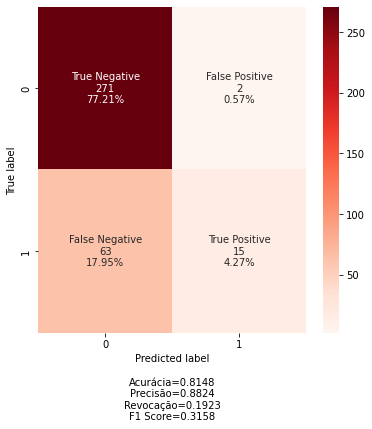

In [200]:
ml_SVC = SVC()

train_model(ml_SVC)

In [226]:
print(metrics.classification_report(y_test, ml_SVC.predict(X_test), target_names=['0','1']))

              precision    recall  f1-score   support

           0       0.81      0.99      0.89       273
           1       0.88      0.19      0.32        78

    accuracy                           0.81       351
   macro avg       0.85      0.59      0.60       351
weighted avg       0.83      0.81      0.76       351



<h3>Naive Bayes</h3>

In [201]:
ml_GNB = CategoricalNB()

train_model(ml_GNB)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



IndexError: ignored

<h3>Árvore de decisão</h3>

True

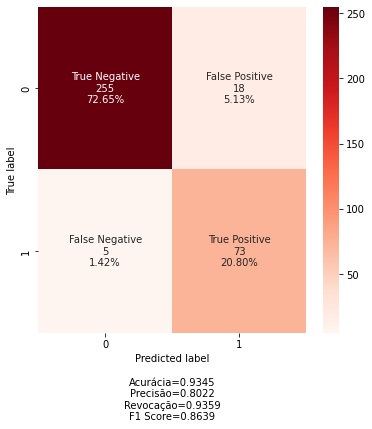

In [202]:
ml_DT = DecisionTreeClassifier(random_state=64)

train_model(ml_DT)

dot_data = StringIO()
export_graphviz(ml_DT, out_file = dot_data, filled = True, rounded = True, special_characters = True, feature_names = X.columns, class_names = ['0','1'])

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('/content/drive/MyDrive/DecisionTree.png')

In [228]:
print(metrics.classification_report(y_test, ml_DT.predict(X_test), target_names=['0','1']))

              precision    recall  f1-score   support

           0       0.98      0.93      0.96       273
           1       0.80      0.94      0.86        78

    accuracy                           0.93       351
   macro avg       0.89      0.93      0.91       351
weighted avg       0.94      0.93      0.94       351



In [203]:
ml_DT

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=64, splitter='best')

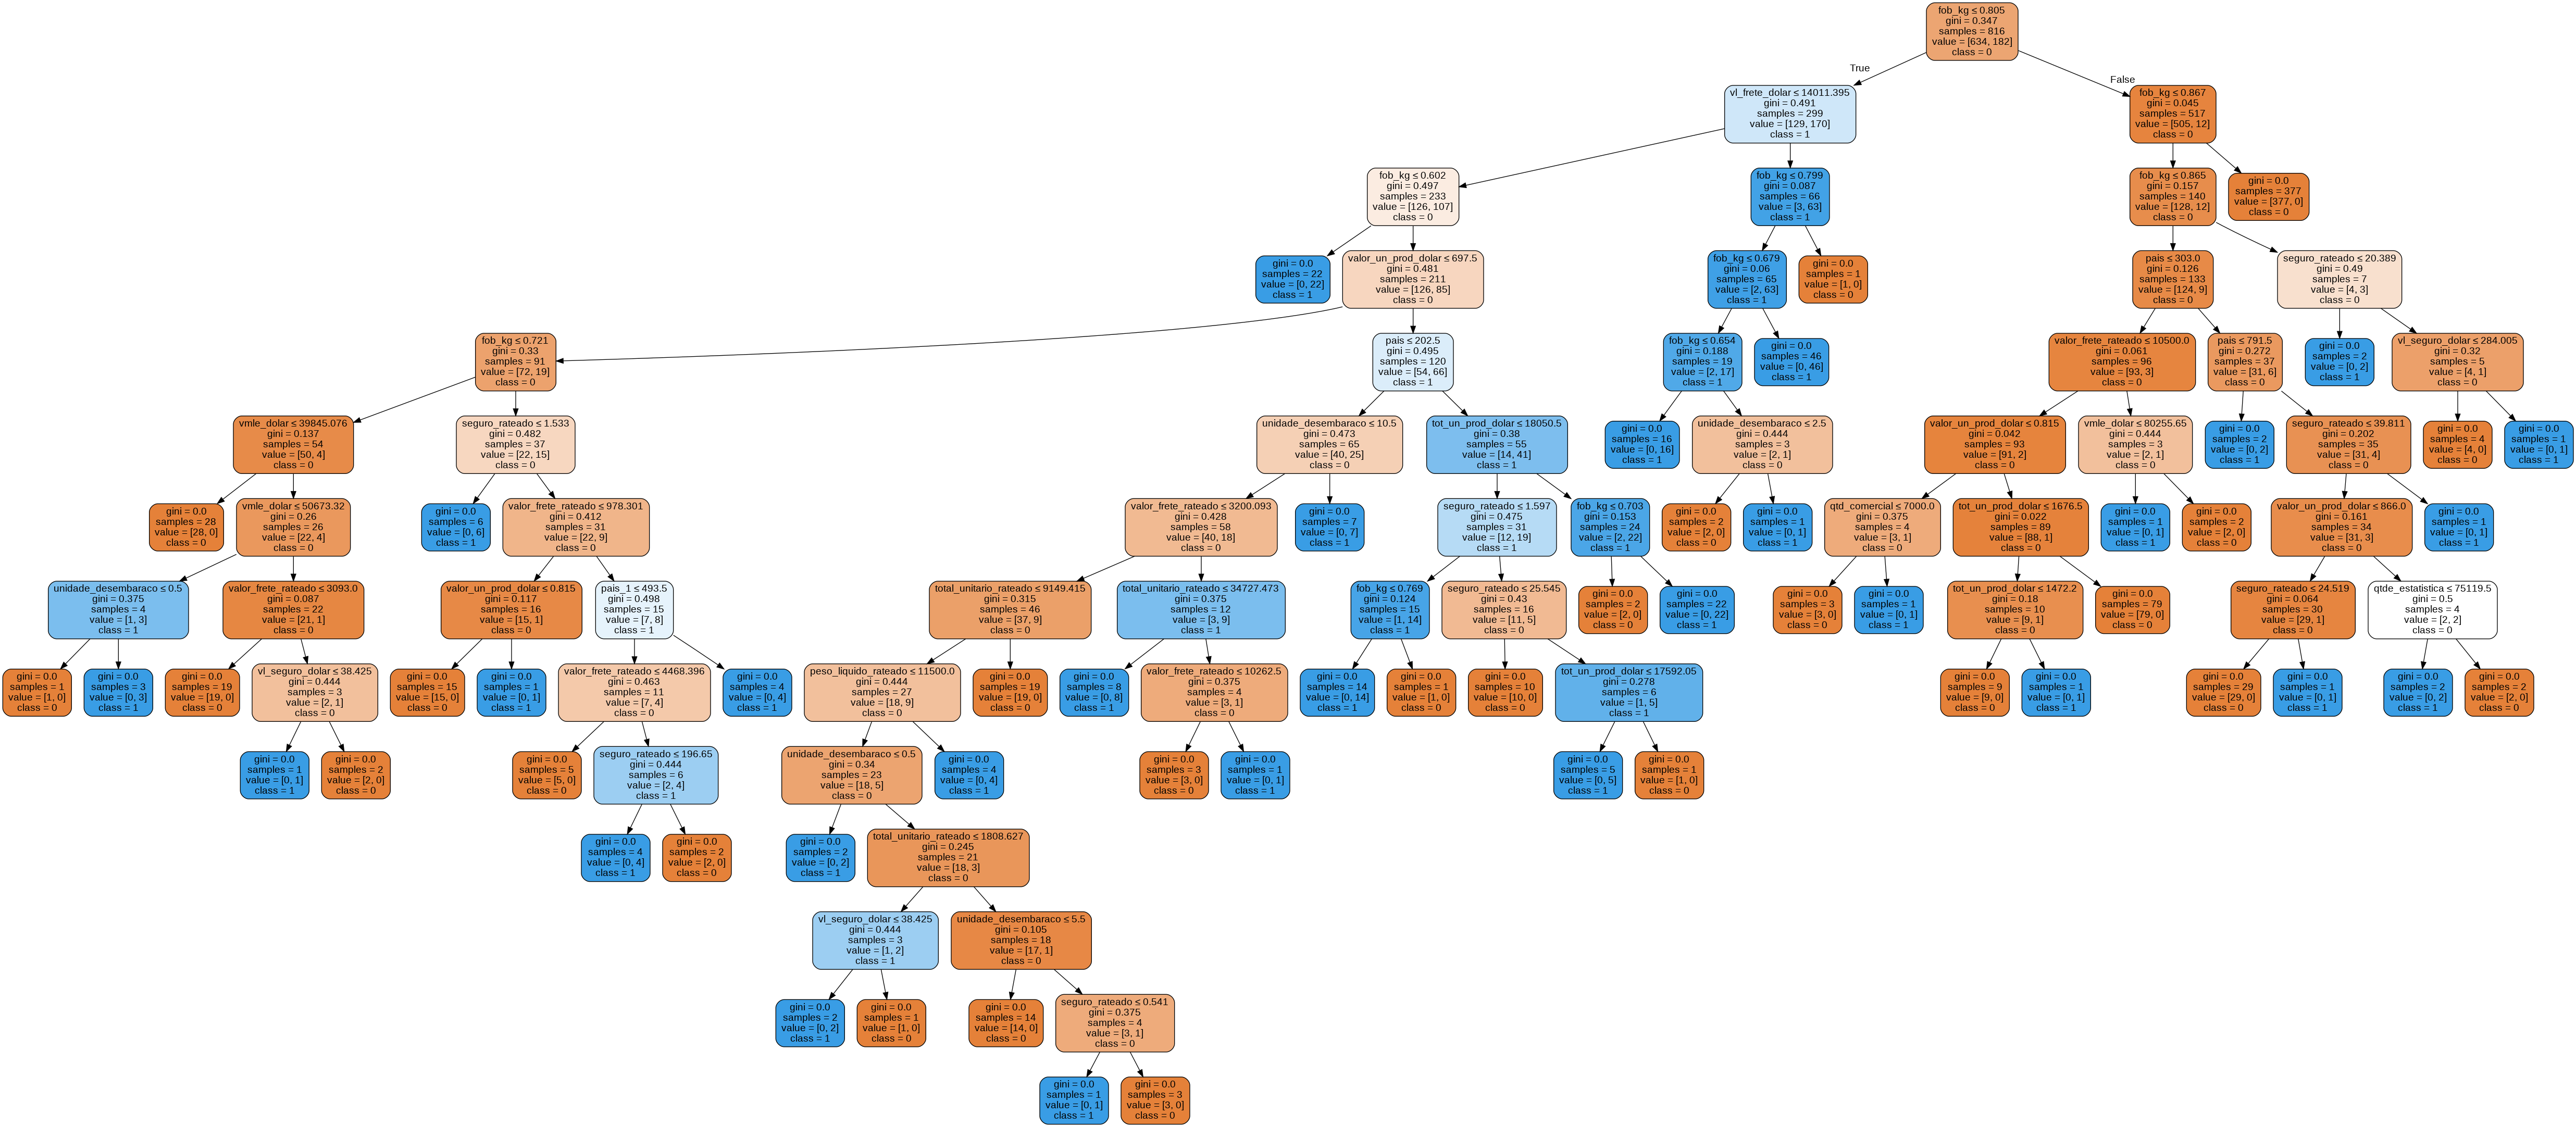

In [204]:
Image(graph.create_png())

In [205]:
y_pred = ml_DT.predict(X_test)
y_pred

array([0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1,
       0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [206]:
print(np.array(y['incompatibil'].to_list()))

[1 1 0 ... 0 0 0]


In [207]:
ml_DT_a_scores_CV = cross_val_score(ml_DT, X_train, y_train, cv = 10)
print(f'Média das Acurácias calculadas pelo CV....: {100*round(ml_DT_a_scores_CV.mean(),4)}')
print(f'std médio das Acurácias calculadas pelo CV: {100*round(ml_DT_a_scores_CV.std(),4)}')
ml_DT_a_scores_CV

Média das Acurácias calculadas pelo CV....: 90.57
std médio das Acurácias calculadas pelo CV: 3.2099999999999995


array([0.84146341, 0.91463415, 0.8902439 , 0.87804878, 0.8902439 ,
       0.96341463, 0.9382716 , 0.91358025, 0.92592593, 0.90123457])

In [209]:
file_name = '/content/drive/MyDrive/ml_DT.pkl'
pickle.dump(ml_DT, open(file_name,'wb'))

In [210]:
def GridSearchOptimizer(modelo, ml_Opt, d_hiperparametros, X_train, y_train, X_test, y_test, i_CV):
    ml_GridSearchCV = GridSearchCV(modelo, d_hiperparametros, cv = i_CV, n_jobs = -1, verbose= 10, scoring = 'accuracy')
    start = time()
    ml_GridSearchCV.fit(X_train, y_train)
    tempo_elapsed = time()-start
    print(f"\nGridSearchCV levou {tempo_elapsed:.2f} segundos.")

    # Hiperparâmetros que otimizam a classificação:
    print(f'\nHiperparâmetros otimizados: {ml_GridSearchCV.best_params_}')

    if ml_Opt == 'ml_DT2':
      print(f'\nDecisionTreeClassifier *********************************************************************************************************')
      ml_Opt = DecisionTreeClassifier(criterion= ml_GridSearchCV.best_params_['criterion'], 
                                    max_depth= ml_GridSearchCV.best_params_['max_depth'],
                                    max_leaf_nodes= ml_GridSearchCV.best_params_['max_leaf_nodes'],
                                    min_samples_split= ml_GridSearchCV.best_params_['min_samples_leaf'],
                                    min_samples_leaf= ml_GridSearchCV.best_params_['min_samples_split'], 
                                    random_state= 64)

    # Treina novamente usando os hiperparâmetros otimizados...
    ml_Opt.fit(X_train, y_train)

    # Cross-Validation com 10 folds
    print(f'\n********* CROSS-VALIDATION ***********')
    ml_DT2_a_scores_CV = cross_val_score(ml_Opt, X_train, y_train, cv = 10)
    print(f'Média das Acurácias calculadas pelo CV....: {100*round(ml_DT2_a_scores_CV.mean(),4)}')
    print(f'std médio das Acurácias calculadas pelo CV: {100*round(ml_DT2_a_scores_CV.std(),4)}')
    print(ml_DT2_a_scores_CV)

    # Faz predições com os hiperparâmetros otimizados...
    y_pred = ml_Opt.predict(X_test)

    # Importância das COLUNAS
    print(f'\n********* IMPORTÂNCIA DAS COLUNAS ***********')
    df_importancia_variaveis = pd.DataFrame(zip(X.columns, ml_Opt.feature_importances_), columns= ['coluna', 'importancia'])
    df_importancia_variaveis = df_importancia_variaveis.sort_values(by= ['importancia'], ascending=False)
    print(df_importancia_variaveis)

    # Matriz de Confusão
    print(f'\n********* CONFUSION MATRIX - PARAMETER TUNNING ***********')
    cf_matrix = confusion_matrix(y_test, y_pred)
    mostra_confusion_matrix(cf_matrix, group_names = cf_labels, categories = cf_categories)

    return ml_Opt, ml_GridSearchCV.best_params_

In [211]:
d_hiperparametros_DT = {"criterion": ["gini", "entropy"], 
                   "min_samples_split": [2, 5, 10, 270, 350, 400], 
                   "max_depth": [None, 2, 5, 9, 15], 
                   "min_samples_leaf": [1.0, 20, 40, 100], 
                   "max_leaf_nodes": [None, 2, 3, 15]}
d_hiperparametros_DT

{'criterion': ['gini', 'entropy'],
 'max_depth': [None, 2, 5, 9, 15],
 'max_leaf_nodes': [None, 2, 3, 15],
 'min_samples_leaf': [1.0, 20, 40, 100],
 'min_samples_split': [2, 5, 10, 270, 350, 400]}

Fitting 10 folds for each of 960 candidates, totalling 9600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1877s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0278s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0413s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0747s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 216 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 360 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 536 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 712 t


GridSearchCV levou 44.89 segundos.

Hiperparâmetros otimizados: {'criterion': 'entropy', 'max_depth': None, 'max_leaf_nodes': None, 'min_samples_leaf': 20, 'min_samples_split': 2}

DecisionTreeClassifier *********************************************************************************************************

********* CROSS-VALIDATION ***********
Média das Acurácias calculadas pelo CV....: 89.83
std médio das Acurácias calculadas pelo CV: 2.44
[0.86585366 0.92682927 0.8902439  0.90243902 0.8902439  0.87804878
 0.91358025 0.88888889 0.95061728 0.87654321]

********* IMPORTÂNCIA DAS COLUNAS ***********
                    coluna  importancia
14                  fob_kg     0.631561
5           vl_frete_dolar     0.156561
3         qtde_estatistica     0.064925
7      valor_un_prod_dolar     0.039237
0                     pais     0.028256
4               vmle_dolar     0.026480
9        tot_un_prod_dolar     0.024148
11     valor_frete_rateado     0.018700
2      unidade_desembaraco    

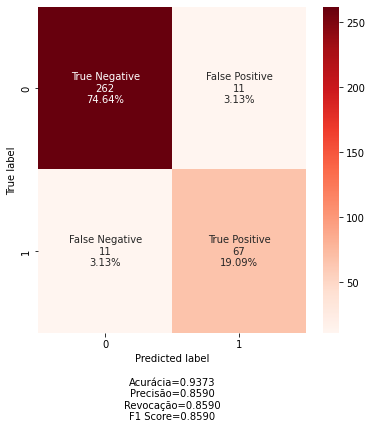

In [212]:
ml_DT2, best_params = GridSearchOptimizer(ml_DT, 'ml_DT2', d_hiperparametros_DT, X_train, y_train, X_test, y_test, i_CV)

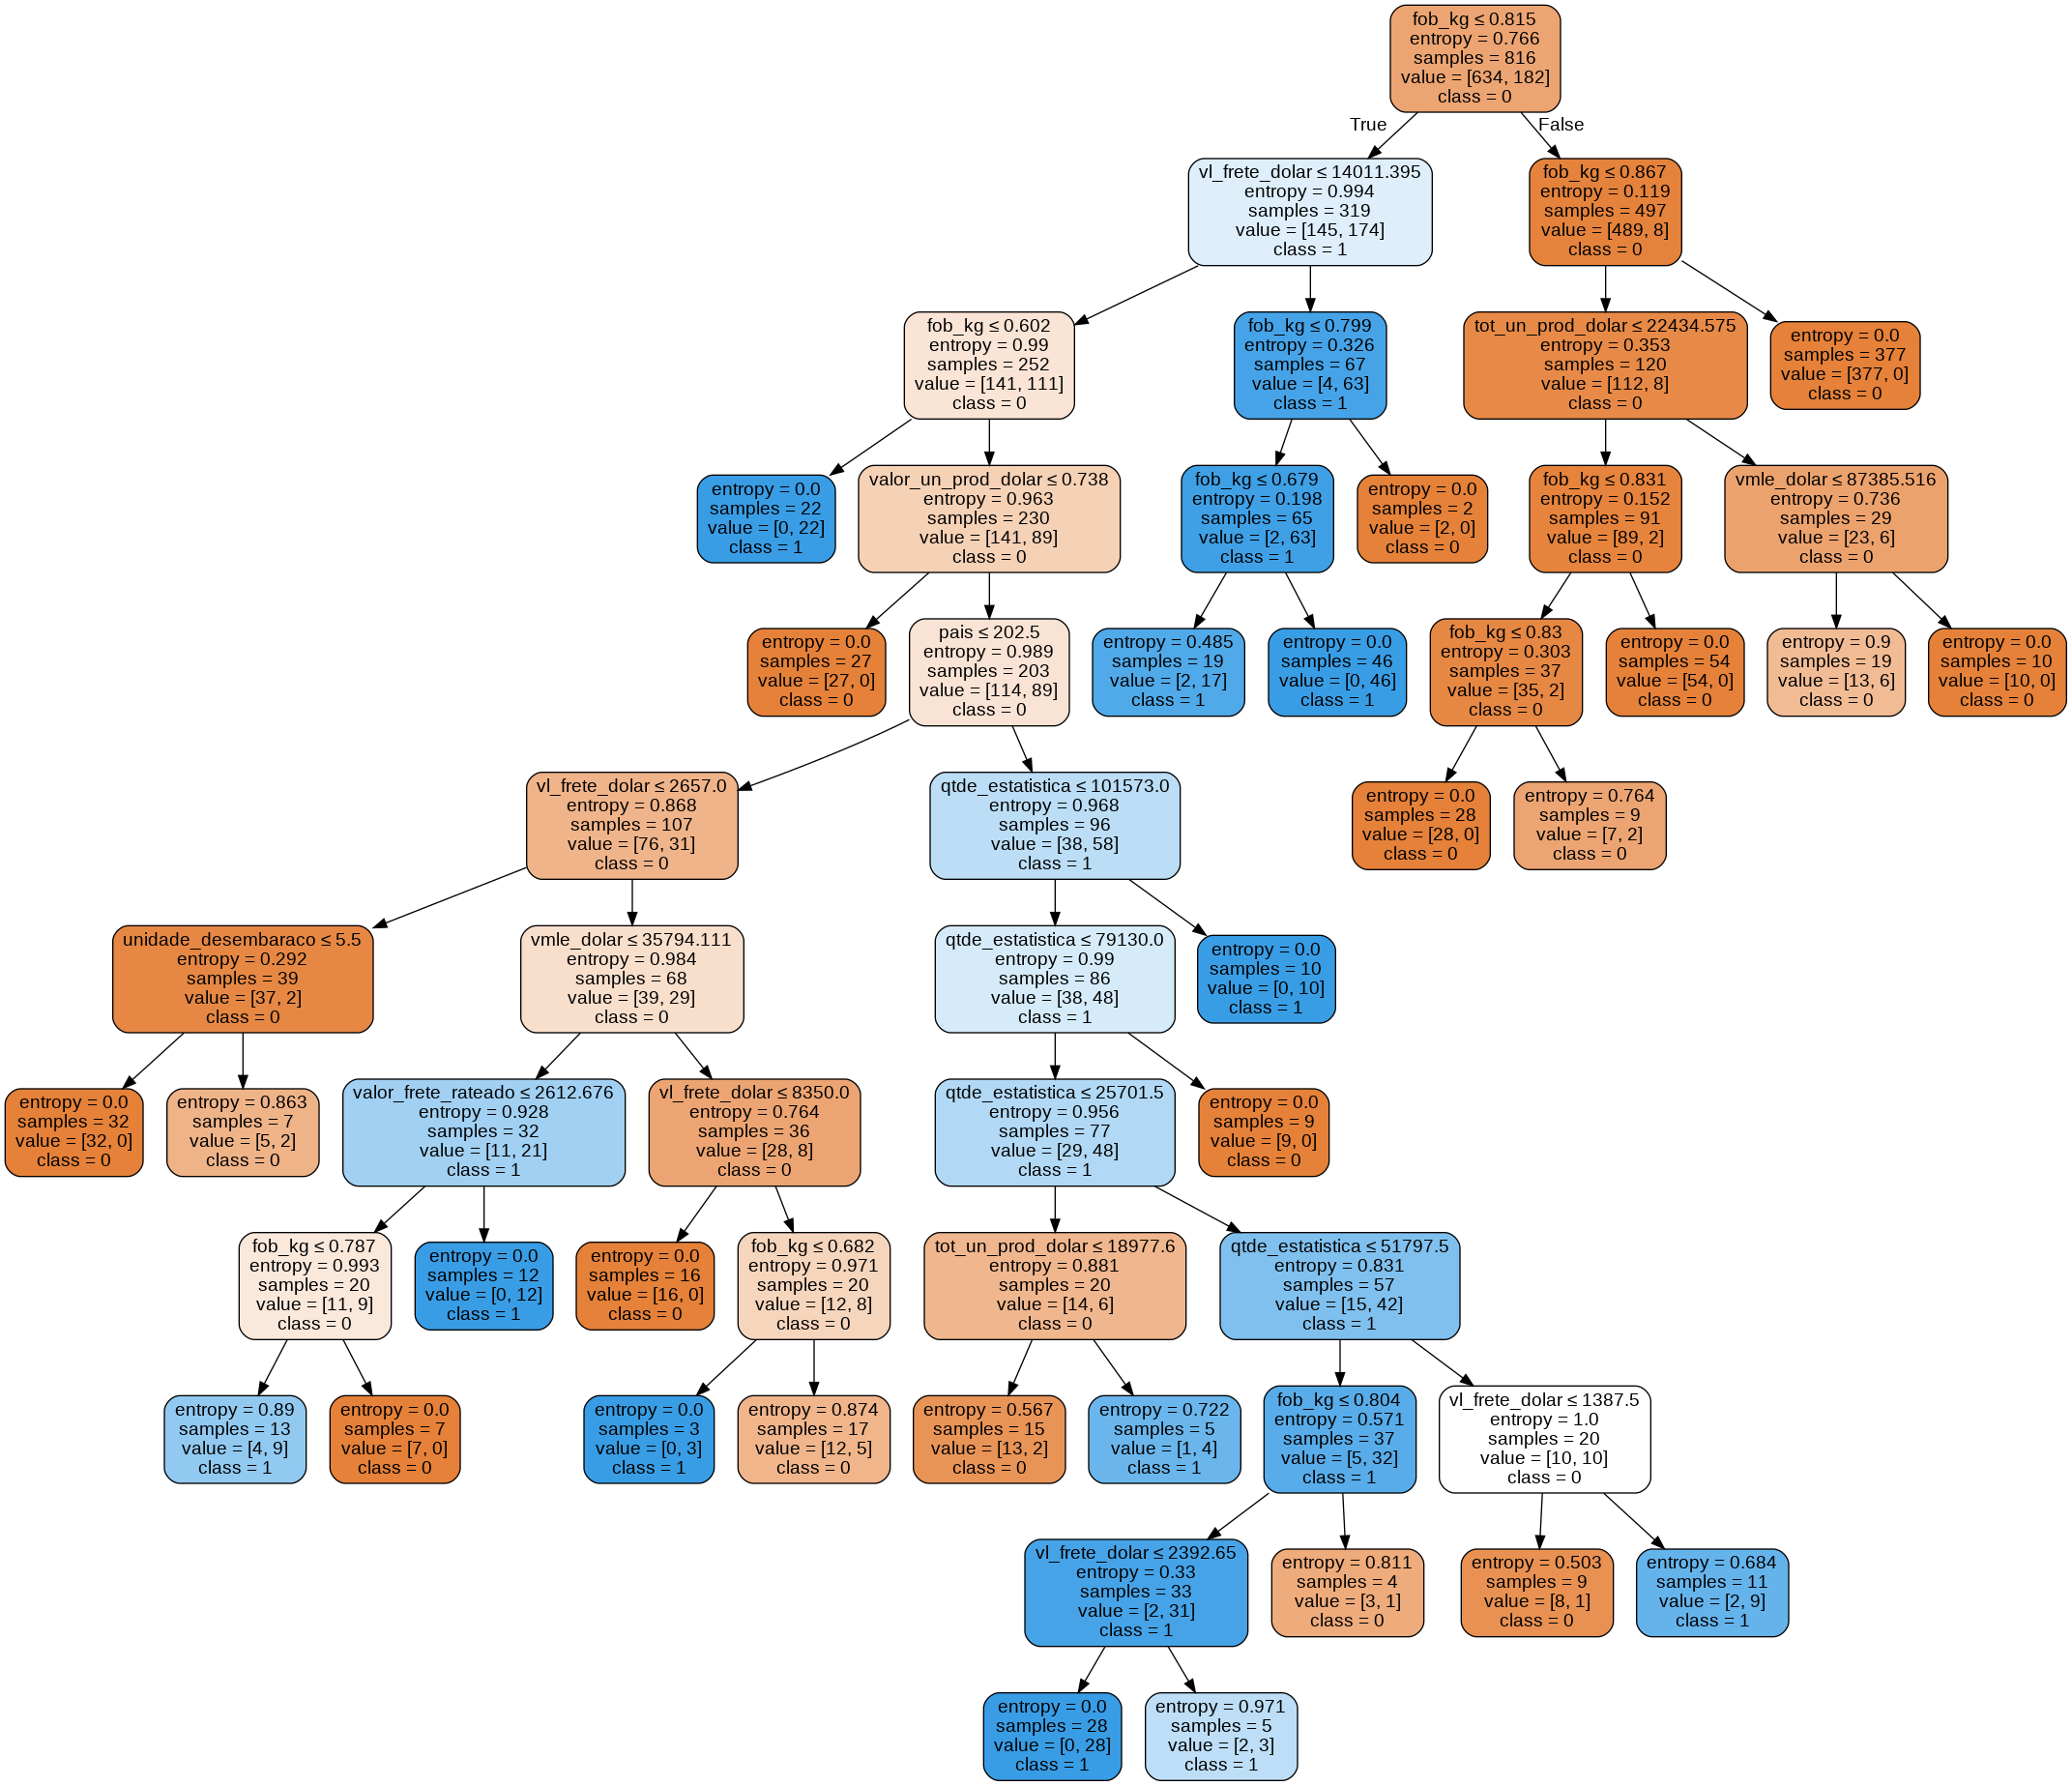

In [213]:
dot_data = StringIO()
export_graphviz(ml_DT2, out_file = dot_data, filled = True, rounded = True, special_characters = True, feature_names = X.columns, class_names = ['0','1'])

graph2 = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph2.write_png('/content/drive/MyDrive/DecisionTree2.png')
Image(graph2.create_png())

In [214]:
file_name = '/content/drive/MyDrive/ml_DT2.pkl'
pickle.dump(ml_DT2, open(file_name,'wb'))

True

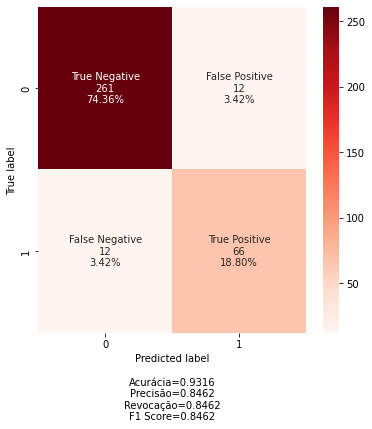

In [215]:
ml_DT3 = DecisionTreeClassifier(criterion='entropy', max_depth= None, max_leaf_nodes=None, min_samples_leaf= 20, min_samples_split= 2, random_state=64)

train_model(ml_DT3)

dot_data = StringIO()
export_graphviz(ml_DT3, out_file = dot_data, filled = True, rounded = True, special_characters = True, feature_names = X.columns, class_names = ['0','1'])

graph3 = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph3.write_png('/content/drive/MyDrive/DecisionTree3.png')

In [229]:
print(metrics.classification_report(y_test, ml_DT3.predict(X_test), target_names=['0','1']))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       273
           1       0.85      0.85      0.85        78

    accuracy                           0.93       351
   macro avg       0.90      0.90      0.90       351
weighted avg       0.93      0.93      0.93       351



In [216]:
ml_DT3

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=20, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=64, splitter='best')

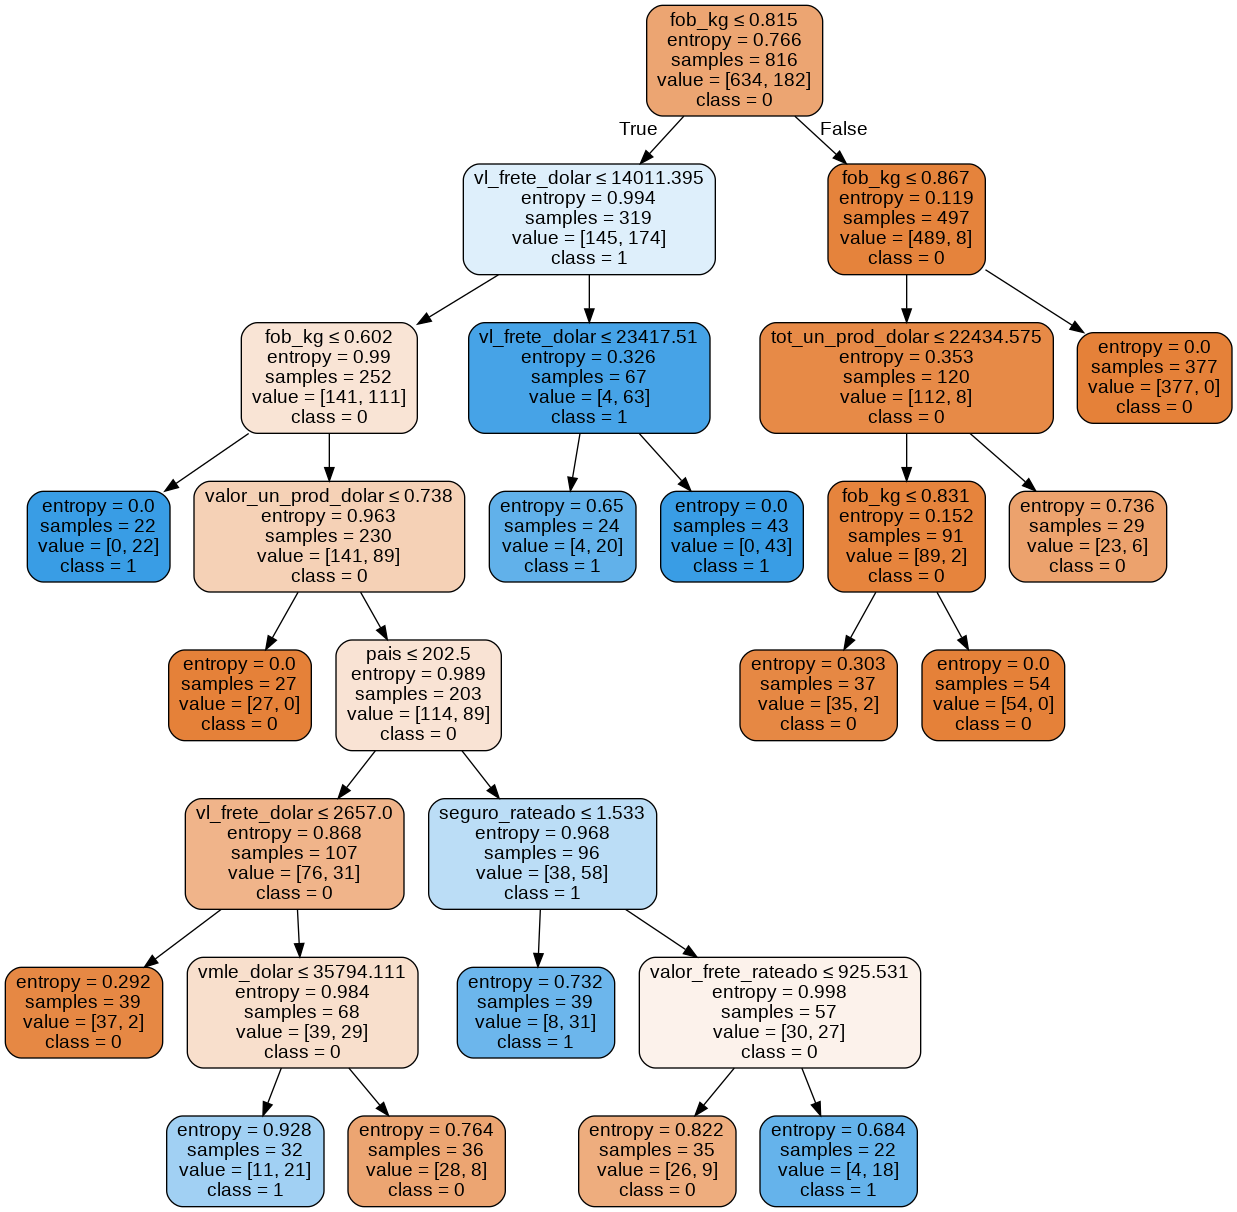

In [217]:
Image(graph3.create_png())

In [218]:
ml_DT3_a_scores_CV = cross_val_score(ml_DT3, X_train, y_train, cv = 10)
print(f'Média das Acurácias calculadas pelo CV....: {100*round(ml_DT3_a_scores_CV.mean(),4)}')
print(f'std médio das Acurácias calculadas pelo CV: {100*round(ml_DT3_a_scores_CV.std(),4)}')
ml_DT3_a_scores_CV

Média das Acurácias calculadas pelo CV....: 89.71000000000001
std médio das Acurácias calculadas pelo CV: 2.0500000000000003


array([0.87804878, 0.91463415, 0.8902439 , 0.8902439 , 0.86585366,
       0.92682927, 0.91358025, 0.92592593, 0.88888889, 0.87654321])

In [219]:
file_name = '/content/drive/MyDrive/ml_DT3.pkl'
pickle.dump(ml_DT3, open(file_name,'wb'))